### This notebook shows an example of using GAN to generate images

Source: https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-6-image-generation-using-gans

## Lab 4

### Use tensorflow/keras/pytorch to implement GANs on Fashion MNIST dataset. The Fashion MNIST Dataset is available under keras.datasets.

In [17]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
import keras.optimizers
from matplotlib import pyplot
import numpy as np
from math import sqrt

In [18]:
# Load and preprocess the Fashion MNIST dataset
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


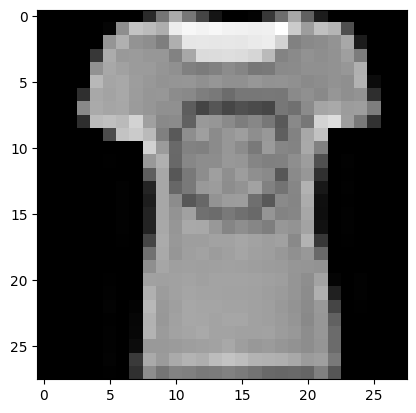

In [19]:
# Display an example image
pyplot.imshow(X_train[441], cmap='gray')

In [20]:
# Function to generate latent points
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [21]:
# Function to generate real samples
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

In [22]:
# Function to generate fake samples
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)
    y = zeros((n_samples, 1))
    return images, y

In [23]:
# Function to summarize the model performance
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'mnist_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [24]:
# Function to save and display generated images
from math import sqrt

def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(int(sqrt(n_examples)), int(sqrt(n_examples)), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [25]:
# Function to define the discriminator model
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
discriminator = define_discriminator()

In [26]:
# Function to define the generator model
def define_generator(latent_dim):
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,))
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model
generator = define_generator(100)

In [27]:
# Function to define the GAN model
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
gan_model = define_gan(generator, discriminator)

In [28]:
# Function to train the GAN
def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    print("bat_per_epo", bat_per_epo, n_steps)
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        z_input = generate_latent_points(latent_dim, n_batch)
        y_gan = ones((n_batch, 1))
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
        if (i+1) % (bat_per_epo * 1) == 0:
            print("call summarize_performance ")
            summarize_performance(i, g_model, latent_dim)## This function saves the model for later use, as the training will take up some time

    return g_model

bat_per_epo 468 4680
4/4 [==============================] - 0s 4ms/step
>1, dr[1.093,0.227], df[0.698,0.062], g[0.688,0.953]
4/4 [==============================] - 0s 3ms/step
>2, dr[0.136,1.000], df[0.710,0.000], g[0.680,1.000]
4/4 [==============================] - 0s 2ms/step
>3, dr[0.046,1.000], df[0.721,0.000], g[0.669,1.000]
4/4 [==============================] - 0s 3ms/step
>4, dr[0.026,1.000], df[0.738,0.000], g[0.656,1.000]
4/4 [==============================] - 0s 3ms/step
>5, dr[0.018,1.000], df[0.758,0.000], g[0.641,1.000]
4/4 [==============================] - 0s 3ms/step
>6, dr[0.022,1.000], df[0.785,0.000], g[0.620,1.000]
4/4 [==============================] - 0s 3ms/step
>7, dr[0.018,1.000], df[0.817,0.000], g[0.602,1.000]
4/4 [==============================] - 0s 3ms/step
>8, dr[0.013,1.000], df[0.845,0.000], g[0.592,1.000]
4/4 [==============================] - 0s 3ms/step
>9, dr[0.016,1.000], df[0.859,0.000], g[0.589,1.000]
4/4 [==============================] - 0s 2

>Saved: mnist_model_0468.h5
4/4 [==============================] - 0s 3ms/step
>469, dr[0.255,0.891], df[0.009,1.000], g[5.223,0.000]
4/4 [==============================] - 0s 3ms/step
>470, dr[0.149,0.938], df[0.081,1.000], g[3.137,0.000]
4/4 [==============================] - 0s 3ms/step
>471, dr[0.027,0.992], df[0.268,0.953], g[5.736,0.000]
4/4 [==============================] - 0s 3ms/step
>472, dr[0.201,0.898], df[0.101,0.992], g[4.485,0.000]
4/4 [==============================] - 0s 3ms/step
>473, dr[0.139,0.953], df[0.173,0.969], g[4.775,0.000]
4/4 [==============================] - 0s 3ms/step
>474, dr[0.230,0.883], df[0.292,0.938], g[6.248,0.000]
4/4 [==============================] - 0s 3ms/step
>475, dr[0.385,0.875], df[0.099,0.992], g[3.719,0.000]
4/4 [==============================] - 0s 3ms/step
>476, dr[0.095,0.930], df[0.477,0.828], g[8.023,0.000]
4/4 [==============================] - 0s 4ms/step
>477, dr[0.820,0.828], df[0.071,1.000], g[3.403,0.000]
4/4 [=============

>Saved: mnist_model_0936.h5
4/4 [==============================] - 0s 3ms/step
>937, dr[0.246,0.883], df[0.190,0.945], g[3.525,0.008]
4/4 [==============================] - 0s 3ms/step
>938, dr[0.273,0.867], df[0.278,0.938], g[3.560,0.016]
4/4 [==============================] - 0s 4ms/step
>939, dr[0.437,0.812], df[0.351,0.891], g[3.471,0.008]
4/4 [==============================] - 0s 3ms/step
>940, dr[0.315,0.836], df[0.159,0.984], g[2.919,0.008]
4/4 [==============================] - 0s 3ms/step
>941, dr[0.229,0.883], df[0.480,0.781], g[4.182,0.000]
4/4 [==============================] - 0s 3ms/step
>942, dr[0.624,0.727], df[0.115,1.000], g[2.597,0.000]
4/4 [==============================] - 0s 3ms/step
>943, dr[0.174,0.891], df[0.473,0.781], g[3.800,0.000]
4/4 [==============================] - 0s 4ms/step
>944, dr[0.418,0.812], df[0.083,1.000], g[3.132,0.000]
4/4 [==============================] - 0s 3ms/step
>945, dr[0.196,0.891], df[0.226,0.945], g[2.803,0.016]
4/4 [=============

>Saved: mnist_model_1404.h5
4/4 [==============================] - 0s 4ms/step
>1405, dr[0.435,0.797], df[0.379,0.898], g[2.961,0.008]
4/4 [==============================] - 0s 8ms/step
>1406, dr[0.480,0.742], df[0.369,0.867], g[2.850,0.023]
4/4 [==============================] - 0s 7ms/step
>1407, dr[0.401,0.781], df[0.283,0.906], g[2.630,0.023]
4/4 [==============================] - 0s 5ms/step
>1408, dr[0.201,0.898], df[0.273,0.930], g[2.869,0.039]
4/4 [==============================] - 0s 4ms/step
>1409, dr[0.442,0.805], df[0.362,0.898], g[2.875,0.047]
4/4 [==============================] - 0s 4ms/step
>1410, dr[0.493,0.750], df[0.425,0.906], g[2.977,0.016]
4/4 [==============================] - 0s 7ms/step
>1411, dr[0.397,0.773], df[0.307,0.930], g[2.745,0.016]
4/4 [==============================] - 0s 5ms/step
>1412, dr[0.354,0.812], df[0.314,0.914], g[2.624,0.008]
4/4 [==============================] - 0s 3ms/step
>1413, dr[0.316,0.812], df[0.365,0.906], g[3.268,0.008]
4/4 [====

>Saved: mnist_model_1872.h5
4/4 [==============================] - 0s 3ms/step
>1873, dr[0.352,0.781], df[0.355,0.883], g[2.653,0.016]
4/4 [==============================] - 0s 4ms/step
>1874, dr[0.471,0.695], df[0.306,0.914], g[2.381,0.008]
4/4 [==============================] - 0s 3ms/step
>1875, dr[0.391,0.773], df[0.333,0.891], g[2.367,0.016]
4/4 [==============================] - 0s 3ms/step
>1876, dr[0.408,0.758], df[0.325,0.891], g[2.542,0.016]
4/4 [==============================] - 0s 3ms/step
>1877, dr[0.502,0.734], df[0.365,0.875], g[2.466,0.031]
4/4 [==============================] - 0s 3ms/step
>1878, dr[0.432,0.742], df[0.352,0.891], g[2.556,0.000]
4/4 [==============================] - 0s 3ms/step
>1879, dr[0.427,0.695], df[0.284,0.953], g[2.575,0.000]
4/4 [==============================] - 0s 4ms/step
>1880, dr[0.356,0.797], df[0.254,0.961], g[2.625,0.000]
4/4 [==============================] - 0s 3ms/step
>1881, dr[0.363,0.797], df[0.394,0.875], g[2.670,0.008]
4/4 [====

>Saved: mnist_model_2340.h5
4/4 [==============================] - 0s 3ms/step
>2341, dr[0.391,0.773], df[0.391,0.836], g[2.361,0.047]
4/4 [==============================] - 0s 4ms/step
>2342, dr[0.400,0.797], df[0.247,0.930], g[2.451,0.008]
4/4 [==============================] - 0s 4ms/step
>2343, dr[0.385,0.750], df[0.324,0.906], g[2.385,0.039]
4/4 [==============================] - 0s 4ms/step
>2344, dr[0.458,0.734], df[0.407,0.836], g[2.409,0.031]
4/4 [==============================] - 0s 4ms/step
>2345, dr[0.473,0.742], df[0.355,0.867], g[2.589,0.008]
4/4 [==============================] - 0s 4ms/step
>2346, dr[0.419,0.727], df[0.362,0.859], g[2.576,0.031]
4/4 [==============================] - 0s 4ms/step
>2347, dr[0.587,0.664], df[0.319,0.898], g[2.242,0.055]
4/4 [==============================] - 0s 4ms/step
>2348, dr[0.378,0.773], df[0.429,0.844], g[2.451,0.023]
4/4 [==============================] - 0s 3ms/step
>2349, dr[0.422,0.758], df[0.331,0.906], g[2.573,0.000]
4/4 [====

>Saved: mnist_model_2808.h5
4/4 [==============================] - 0s 4ms/step
>2809, dr[0.500,0.680], df[0.456,0.875], g[2.043,0.055]
4/4 [==============================] - 0s 5ms/step
>2810, dr[0.552,0.656], df[0.342,0.891], g[1.885,0.031]
4/4 [==============================] - 0s 3ms/step
>2811, dr[0.390,0.734], df[0.512,0.781], g[2.057,0.016]
4/4 [==============================] - 0s 4ms/step
>2812, dr[0.552,0.680], df[0.354,0.891], g[2.096,0.016]
4/4 [==============================] - 0s 3ms/step
>2813, dr[0.417,0.781], df[0.378,0.875], g[2.101,0.031]
4/4 [==============================] - 0s 3ms/step
>2814, dr[0.472,0.711], df[0.286,0.961], g[2.185,0.016]
4/4 [==============================] - 0s 3ms/step
>2815, dr[0.477,0.734], df[0.509,0.805], g[2.167,0.008]
4/4 [==============================] - 0s 6ms/step
>2816, dr[0.421,0.773], df[0.277,0.938], g[2.189,0.031]
4/4 [==============================] - 0s 4ms/step
>2817, dr[0.507,0.672], df[0.274,0.953], g[2.137,0.031]
4/4 [====

>Saved: mnist_model_3276.h5
4/4 [==============================] - 0s 5ms/step
>3277, dr[0.346,0.820], df[0.506,0.828], g[1.869,0.070]
4/4 [==============================] - 0s 4ms/step
>3278, dr[0.552,0.695], df[0.326,0.898], g[1.922,0.016]
4/4 [==============================] - 0s 4ms/step
>3279, dr[0.635,0.617], df[0.402,0.859], g[1.744,0.062]
4/4 [==============================] - 0s 5ms/step
>3280, dr[0.486,0.711], df[0.420,0.891], g[1.771,0.070]
4/4 [==============================] - 0s 4ms/step
>3281, dr[0.406,0.734], df[0.513,0.812], g[1.942,0.039]
4/4 [==============================] - 0s 2ms/step
>3282, dr[0.648,0.602], df[0.420,0.844], g[1.760,0.031]
4/4 [==============================] - 0s 4ms/step
>3283, dr[0.565,0.656], df[0.390,0.898], g[1.773,0.023]
4/4 [==============================] - 0s 3ms/step
>3284, dr[0.574,0.602], df[0.501,0.875], g[1.757,0.047]
4/4 [==============================] - 0s 4ms/step
>3285, dr[0.443,0.734], df[0.381,0.883], g[1.843,0.023]
4/4 [====

>Saved: mnist_model_3744.h5
4/4 [==============================] - 0s 5ms/step
>3745, dr[0.464,0.695], df[0.371,0.906], g[1.758,0.039]
4/4 [==============================] - 0s 5ms/step
>3746, dr[0.611,0.602], df[0.422,0.898], g[1.730,0.023]
4/4 [==============================] - 0s 4ms/step
>3747, dr[0.459,0.719], df[0.425,0.875], g[1.693,0.055]
4/4 [==============================] - 0s 4ms/step
>3748, dr[0.429,0.766], df[0.350,0.898], g[1.672,0.055]
4/4 [==============================] - 0s 5ms/step
>3749, dr[0.452,0.734], df[0.410,0.922], g[1.698,0.031]
4/4 [==============================] - 0s 5ms/step
>3750, dr[0.653,0.602], df[0.434,0.836], g[1.560,0.102]
4/4 [==============================] - 0s 3ms/step
>3751, dr[0.521,0.672], df[0.508,0.805], g[1.583,0.070]
4/4 [==============================] - 0s 4ms/step
>3752, dr[0.388,0.750], df[0.403,0.859], g[1.679,0.094]
4/4 [==============================] - 0s 3ms/step
>3753, dr[0.524,0.633], df[0.517,0.852], g[1.748,0.023]
4/4 [====

>Saved: mnist_model_4212.h5
4/4 [==============================] - 0s 5ms/step
>4213, dr[0.508,0.688], df[0.505,0.812], g[1.607,0.070]
4/4 [==============================] - 0s 5ms/step
>4214, dr[0.504,0.688], df[0.441,0.875], g[1.663,0.039]
4/4 [==============================] - 0s 6ms/step
>4215, dr[0.500,0.719], df[0.480,0.828], g[1.565,0.047]
4/4 [==============================] - 0s 4ms/step
>4216, dr[0.512,0.672], df[0.386,0.906], g[1.677,0.062]
4/4 [==============================] - 0s 5ms/step
>4217, dr[0.474,0.680], df[0.461,0.836], g[1.697,0.039]
4/4 [==============================] - 0s 4ms/step
>4218, dr[0.489,0.688], df[0.372,0.891], g[1.689,0.047]
4/4 [==============================] - 0s 4ms/step
>4219, dr[0.453,0.711], df[0.492,0.836], g[1.721,0.055]
4/4 [==============================] - 0s 4ms/step
>4220, dr[0.664,0.586], df[0.434,0.859], g[1.607,0.086]
4/4 [==============================] - 0s 4ms/step
>4221, dr[0.432,0.773], df[0.388,0.875], g[1.766,0.016]
4/4 [====

>Saved: mnist_model_4680.h5


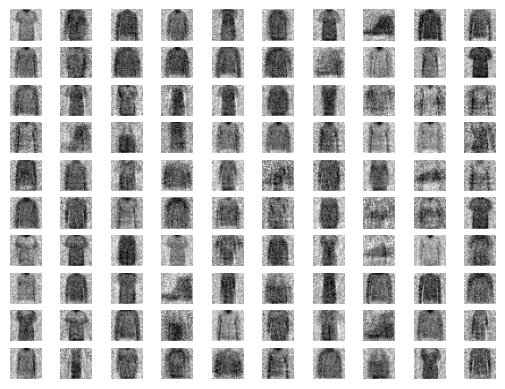

In [29]:
latent_dim = 100
# Train the GAN model
gan = train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=10, n_batch=128)

2/2 [==============================] - 0s 6ms/step


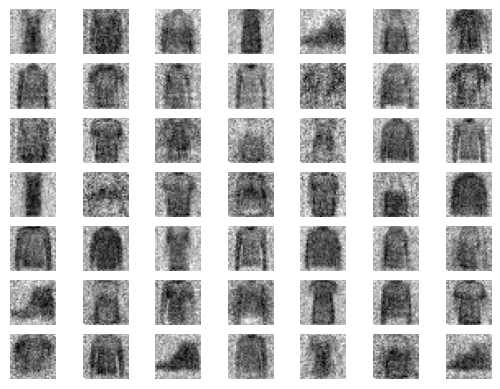

In [30]:
# Load the pre-trained GAN model
gan = load_model('/content/mnist_model_4680.h5')
latent_dim = 100  # Set the dimension of the latent space
n_examples = 49  # Define the number of examples to generate
latent_points = generate_latent_points(latent_dim, n_examples)  # Generate latent points
X  = gan.predict(latent_points)  # Predict images using the GAN
X = (X + 1) / 2.0  # Adjust the generated images
n_examples = round(n_examples)   # Round the number of examples
save_plot(X, n_examples)  # Save and display the generated images